In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split
import evaluation
import strategy

In [2]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [14]:
series = data[['Close']]
series

,Close
Date,
1993-01-29,25.717382
1993-02-01,25.900291
1993-02-02,25.955153
1993-02-03,26.229538
1993-02-04,26.339287
...,...
2020-12-24,365.425323
2020-12-28,368.564636
2020-12-29,367.861481


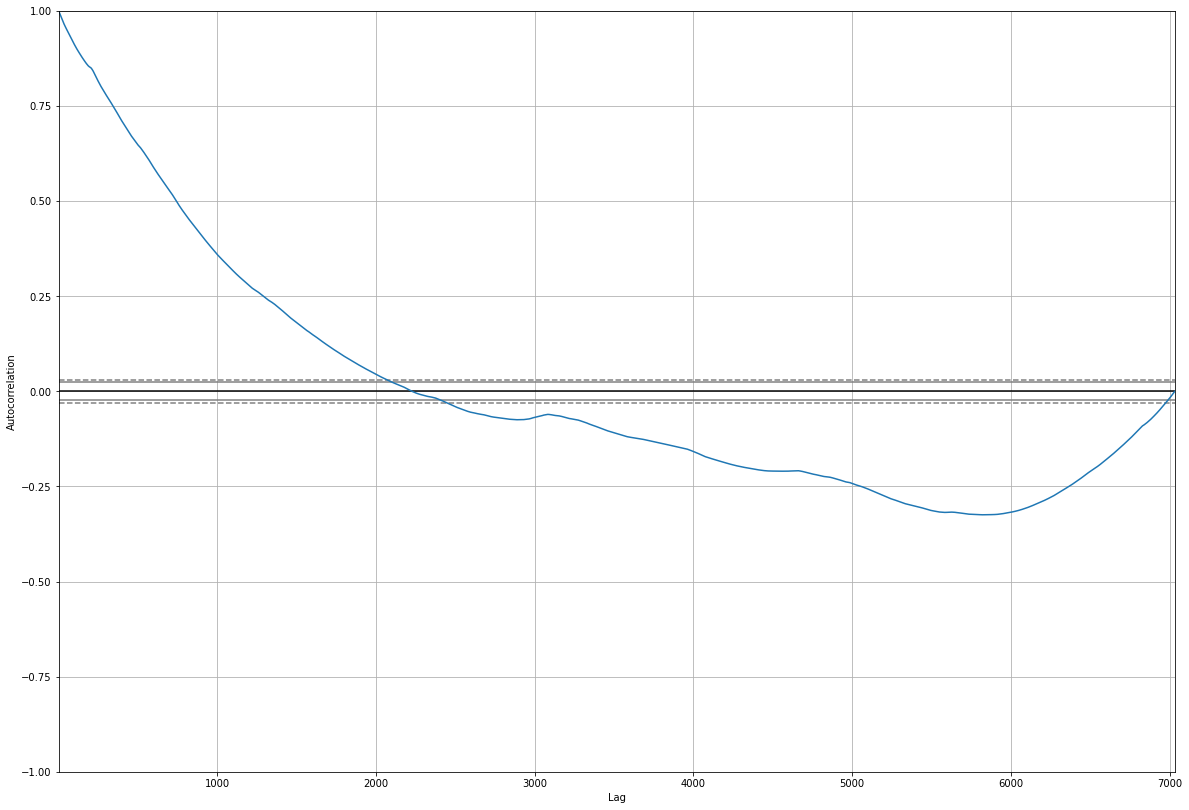

In [15]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,14))
autocorrelation_plot(series)
plt.show()

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 7033
Model:                ARIMA(30, 1, 0)   Log Likelihood              -13078.038
Date:                Wed, 01 Dec 2021   AIC                          26218.075
Time:                        22:56:24   BIC                          26430.680
Sample:                             0   HQIC                         26291.319
                               - 7033                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1013      0.004    -23.750      0.000      -0.110      -0.093
ar.L2          0.0572      0.004     13.804      0.000       0.049       0.065
ar.L3          0.0298      0.005      6.283      0.0

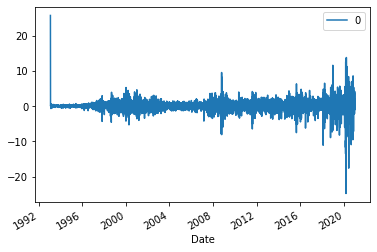

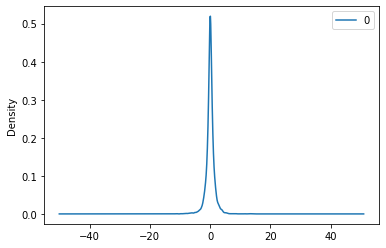

                 0
count  7033.000000
mean      0.056881
std       1.582910
min     -24.796053
25%      -0.450054
50%       0.060952
75%       0.598902
max      25.717382


In [70]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(series, order=(30,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [103]:
model = ARIMA(train, order=(20,1,2))
model_fit = model.fit()

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [109]:
model_fit.forecast(5)

array([84.40681812, 84.41782902, 84.5375412 , 84.63234706, 84.5849941 ])

In [108]:
test[:5]

array([82.6601181 , 84.43350983, 81.98719025, 82.58889008, 82.85015869])

In [69]:
size = int(len(series) * 0.6)

train, test = series[:size]['Close'].to_numpy(), series[size:]['Close'].to_numpy()

history = train
predictions = []
dirs = []

# walk-forward validation
for real in test:
    prev = history[-1]

    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    pred = model_fit.forecast(30, )[0]
    predictions.append(pred)
    history = np.append(history, real)
    
    predchange = 100 * (pred - prev) / prev
    realchange = 100 * (real - prev) / prev
    
    direction = (
        (predchange > 0 and realchange > 0) or
        (predchange < 0 and realchange < 0)
    )
    dirs.append(direction)

    print(f"\
pred={round(pred, 4)}, \
real={round(real, 4)}, \
predchange={round(predchange, 2)}, \
realchange={round(realchange, 2)}, \
      \tdir = {direction}  \t[{sum(dirs)}/{len(dirs)}] {round(sum(dirs) / len(dirs), 2)}"
    )

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

pred=84.3769, real=82.6601, predchange=0.15, realchange=-1.89,       	dir = False  	[0/1] 0.0
pred=82.7761, real=84.4335, predchange=0.14, realchange=2.15,       	dir = True  	[1/2] 0.5
pred=84.5609, real=81.9872, predchange=0.15, realchange=-2.9,       	dir = False  	[1/3] 0.33
pred=82.158, real=82.5889, predchange=0.21, realchange=0.73,       	dir = True  	[2/4] 0.5
pred=82.7609, real=82.8502, predchange=0.21, realchange=0.32,       	dir = True  	[3/5] 0.6
pred=82.7857, real=83.0639, predchange=-0.08, realchange=0.26,       	dir = False  	[3/6] 0.5
pred=83.1345, real=84.5919, predchange=0.09, realchange=1.84,       	dir = True  	[4/7] 0.57
pred=84.4831, real=84.8135, predchange=-0.13, realchange=0.26,       	dir = False  	[4/8] 0.5
pred=84.5447, real=86.7453, predchange=-0.32, realchange=2.28,       	dir = False  	[4/9] 0.44
pred=86.7248, real=86.7611, predchange=-0.02, realchange=0.02,       	dir = False  	[4/10] 0.4
pred=86.4151, real=87.2044, predchange=-0.4, realchange=0.51,     

pred=89.3937, real=89.6558, predchange=0.01, realchange=0.3,       	dir = True  	[46/87] 0.53
pred=89.6742, real=90.9373, predchange=0.02, realchange=1.43,       	dir = True  	[47/88] 0.53
pred=90.82, real=90.9532, predchange=-0.13, realchange=0.02,       	dir = False  	[47/89] 0.53
pred=90.8394, real=91.1044, predchange=-0.13, realchange=0.17,       	dir = False  	[47/90] 0.52
pred=91.0522, real=91.5104, predchange=-0.06, realchange=0.45,       	dir = False  	[47/91] 0.52
pred=91.4009, real=91.8924, predchange=-0.12, realchange=0.42,       	dir = False  	[47/92] 0.51
pred=91.7613, real=91.9004, predchange=-0.14, realchange=0.01,       	dir = False  	[47/93] 0.51
pred=91.9169, real=91.9243, predchange=0.02, realchange=0.03,       	dir = True  	[48/94] 0.51
pred=91.8657, real=92.6566, predchange=-0.06, realchange=0.8,       	dir = False  	[48/95] 0.51
pred=92.6062, real=93.2057, predchange=-0.05, realchange=0.59,       	dir = False  	[48/96] 0.5
pred=93.1555, real=93.158, predchange=-0.

pred=82.2831, real=82.6077, predchange=0.26, realchange=0.66,       	dir = True  	[90/172] 0.52
pred=82.4606, real=85.2096, predchange=-0.18, realchange=3.15,       	dir = False  	[90/173] 0.52
pred=85.1834, real=86.0527, predchange=-0.03, realchange=0.99,       	dir = False  	[90/174] 0.52
pred=85.7601, real=86.6952, predchange=-0.34, realchange=0.75,       	dir = False  	[90/175] 0.51
pred=86.4619, real=86.7513, predchange=-0.27, realchange=0.06,       	dir = False  	[90/176] 0.51
pred=86.6639, real=88.0603, predchange=-0.1, realchange=1.51,       	dir = False  	[90/177] 0.51
pred=87.8778, real=88.0523, predchange=-0.21, realchange=-0.01,       	dir = True  	[91/178] 0.51
pred=87.8346, real=88.0764, predchange=-0.25, realchange=0.03,       	dir = False  	[91/179] 0.51
pred=87.8339, real=85.6512, predchange=-0.28, realchange=-2.75,       	dir = True  	[92/180] 0.51
pred=85.6141, real=86.1571, predchange=-0.04, realchange=0.59,       	dir = False  	[92/181] 0.51
pred=86.1948, real=87.1

pred=96.4101, real=96.8392, predchange=-0.04, realchange=0.4,       	dir = False  	[131/257] 0.51
pred=96.7291, real=98.7041, predchange=-0.11, realchange=1.93,       	dir = False  	[131/258] 0.51
pred=98.5388, real=99.0755, predchange=-0.17, realchange=0.38,       	dir = False  	[131/259] 0.51
pred=98.9195, real=98.8898, predchange=-0.16, realchange=-0.19,       	dir = True  	[132/260] 0.51
pred=98.9448, real=98.1793, predchange=0.06, realchange=-0.72,       	dir = False  	[132/261] 0.51
pred=98.1224, real=98.5749, predchange=-0.06, realchange=0.4,       	dir = False  	[132/262] 0.5
pred=98.5576, real=98.2036, predchange=-0.02, realchange=-0.38,       	dir = True  	[133/263] 0.51
pred=98.2035, real=97.041, predchange=-0.0, realchange=-1.18,       	dir = True  	[134/264] 0.51
pred=97.0177, real=96.9037, predchange=-0.02, realchange=-0.14,       	dir = True  	[135/265] 0.51
pred=97.0505, real=95.3941, predchange=0.15, realchange=-1.56,       	dir = False  	[135/266] 0.51
pred=95.5273, r

pred=108.1282, real=107.5094, predchange=-0.18, realchange=-0.75,       	dir = True  	[171/340] 0.5
pred=107.461, real=106.6653, predchange=-0.05, realchange=-0.79,       	dir = True  	[172/341] 0.5
pred=106.8184, real=107.5987, predchange=0.14, realchange=0.88,       	dir = True  	[173/342] 0.51
pred=107.6128, real=107.4444, predchange=0.01, realchange=-0.14,       	dir = False  	[173/343] 0.5
pred=107.2074, real=105.4561, predchange=-0.22, realchange=-1.85,       	dir = True  	[174/344] 0.51
pred=105.5148, real=106.1865, predchange=0.06, realchange=0.69,       	dir = True  	[175/345] 0.51
pred=106.3076, real=105.5454, predchange=0.11, realchange=-0.6,       	dir = False  	[175/346] 0.51
pred=105.6488, real=104.3361, predchange=0.1, realchange=-1.15,       	dir = False  	[175/347] 0.5
pred=104.5304, real=102.4045, predchange=0.19, realchange=-1.85,       	dir = False  	[175/348] 0.5
pred=102.5407, real=103.7599, predchange=0.13, realchange=1.32,       	dir = True  	[176/349] 0.5
pred=

pred=107.9232, real=109.6995, predchange=-0.17, realchange=1.48,       	dir = False  	[214/423] 0.51
pred=109.4094, real=109.6093, predchange=-0.26, realchange=-0.08,       	dir = True  	[215/424] 0.51
pred=109.4568, real=109.7405, predchange=-0.14, realchange=0.12,       	dir = False  	[215/425] 0.51
pred=109.8585, real=110.879, predchange=0.11, realchange=1.04,       	dir = True  	[216/426] 0.51
pred=110.704, real=110.0927, predchange=-0.16, realchange=-0.71,       	dir = True  	[217/427] 0.51
pred=109.9229, real=108.1022, predchange=-0.15, realchange=-1.81,       	dir = True  	[218/428] 0.51
pred=108.3013, real=107.6352, predchange=0.18, realchange=-0.43,       	dir = False  	[218/429] 0.51
pred=107.6013, real=107.9956, predchange=-0.03, realchange=0.33,       	dir = False  	[218/430] 0.51
pred=108.0972, real=107.2502, predchange=0.09, realchange=-0.69,       	dir = False  	[218/431] 0.51
pred=107.3801, real=107.8728, predchange=0.12, realchange=0.58,       	dir = True  	[219/432] 0

KeyboardInterrupt: 

In [66]:
sum(dirs) / len(dirs)

0.5416666666666666

In [87]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data['price'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
price = data[['price']]

In [88]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    length = len(data)
    
    test_size = int(np.round(0.2*length))
    valid_size = test_size
    train_size = length - test_size - valid_size
    
    x_train = data[:train_size, :-1, :]
    y_train = data[:train_size,  -1, :]
    
    x_valid = data[train_size:train_size+valid_size, :-1, :]
    y_valid = data[train_size:train_size+valid_size,  -1, :]
    
    x_test = data[train_size+valid_size:, :-1]
    y_test = data[train_size+valid_size:,  -1, :]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [150]:
lookback = 100 # choose sequence length

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ', x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_valid_tensor = torch.from_numpy(x_valid).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_valid_tensor = torch.from_numpy(y_valid).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (4159, 99, 1)
y_train.shape =  (4159, 1)
x_valid.shape =  (1387, 99, 1)
y_valid.shape =  (1387, 1)
x_test.shape =  (1387, 99, 1)
y_test.shape =  (1387, 1)


In [151]:
class LSTM(nn.Module):
    def __init__(self, nin, nhidden, nlayers, nout):
        super(LSTM, self).__init__()
        self.nhidden = nhidden
        self.nlayers = nlayers
        
        self.lstm = nn.LSTM(nin, nhidden, nlayers, batch_first=True)
        self.fc = nn.Linear(nhidden, nout)

    def forward(self, x):
        h0 = torch.zeros(self.nlayers, x.size(0), self.nhidden).requires_grad_()
        c0 = torch.zeros(self.nlayers, x.size(0), self.nhidden).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [152]:
import time

nin = 1
nhidden = 64
nlayers = 2
nout = 1

model = LSTM(nin=nin, nhidden=nhidden, nout=nout, nlayers=nlayers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 300

train_losses = np.zeros(num_epochs)
valid_losses = np.zeros(num_epochs)

start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train_tensor)
    y_valid_pred = model(x_valid_tensor)

    train_loss = criterion(y_train_pred, y_train_tensor)
    valid_loss = criterion(y_valid_pred, y_valid_tensor)

    print(f"Epoch {t}: Train MSE: {train_loss.item()}, Validation MSE: {valid_loss.item()}")
    train_losses[t] = train_loss.item()
    valid_losses[t] = valid_loss.item()

    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

print(f"Training time: {time.time() - start_time}")

Epoch 0: Train MSE: 0.005043636076152325, Validation MSE: 0.03529467061161995
Epoch 1: Train MSE: 0.02118641324341297, Validation MSE: 0.08577365428209305
Epoch 2: Train MSE: 0.007556420750916004, Validation MSE: 0.015564796514809132
Epoch 3: Train MSE: 0.006977038457989693, Validation MSE: 0.01889166794717312
Epoch 4: Train MSE: 0.004786950536072254, Validation MSE: 0.031829167157411575
Epoch 5: Train MSE: 0.0055877435952425, Validation MSE: 0.04378146305680275
Epoch 6: Train MSE: 0.006049261428415775, Validation MSE: 0.046735070645809174
Epoch 7: Train MSE: 0.005526479333639145, Validation MSE: 0.043335847556591034
Epoch 8: Train MSE: 0.00496746925637126, Validation MSE: 0.037989262491464615
Epoch 9: Train MSE: 0.004799005575478077, Validation MSE: 0.03298160061240196
Epoch 10: Train MSE: 0.004945063032209873, Validation MSE: 0.029233843088150024
Epoch 11: Train MSE: 0.005136061459779739, Validation MSE: 0.027082262560725212
Epoch 12: Train MSE: 0.0051597789861261845, Validation MSE:

Epoch 104: Train MSE: 0.005175415426492691, Validation MSE: 0.03946308046579361
Epoch 105: Train MSE: 0.005215593613684177, Validation MSE: 0.04008342698216438
Epoch 106: Train MSE: 0.005231357645243406, Validation MSE: 0.04032330960035324
Epoch 107: Train MSE: 0.005220471881330013, Validation MSE: 0.040212832391262054
Epoch 108: Train MSE: 0.005187173839658499, Validation MSE: 0.039798472076654434
Epoch 109: Train MSE: 0.005139783024787903, Validation MSE: 0.03913842886686325
Epoch 110: Train MSE: 0.0050881593488156796, Validation MSE: 0.03829795867204666
Epoch 111: Train MSE: 0.005041407886892557, Validation MSE: 0.03734497353434563
Epoch 112: Train MSE: 0.005006107501685619, Validation MSE: 0.03634607791900635
Epoch 113: Train MSE: 0.00498530687764287, Validation MSE: 0.03536321595311165
Epoch 114: Train MSE: 0.0049783410504460335, Validation MSE: 0.0344509556889534
Epoch 115: Train MSE: 0.004981465637683868, Validation MSE: 0.03365432471036911
Epoch 116: Train MSE: 0.00498912436887

Epoch 206: Train MSE: 5.411238453234546e-05, Validation MSE: 0.00017392370500601828
Epoch 207: Train MSE: 7.303267921088263e-05, Validation MSE: 0.00010598405060591176
Epoch 208: Train MSE: 8.122926374198869e-05, Validation MSE: 0.00015981185424607247
Epoch 209: Train MSE: 0.00010754820686997846, Validation MSE: 0.0004576537467073649
Epoch 210: Train MSE: 0.00015676826296839863, Validation MSE: 0.0008141234866343439
Epoch 211: Train MSE: 0.00017911077884491533, Validation MSE: 0.0009715367341414094
Epoch 212: Train MSE: 0.000173200445715338, Validation MSE: 0.0008933705976232886
Epoch 213: Train MSE: 0.00016854591376613826, Validation MSE: 0.0007211844786070287
Epoch 214: Train MSE: 0.0001627732126507908, Validation MSE: 0.0005850589368492365
Epoch 215: Train MSE: 0.0001364673225907609, Validation MSE: 0.0005204006447456777
Epoch 216: Train MSE: 0.00010124444088432938, Validation MSE: 0.0005002108518965542
Epoch 217: Train MSE: 7.875879964558408e-05, Validation MSE: 0.00046548413229174

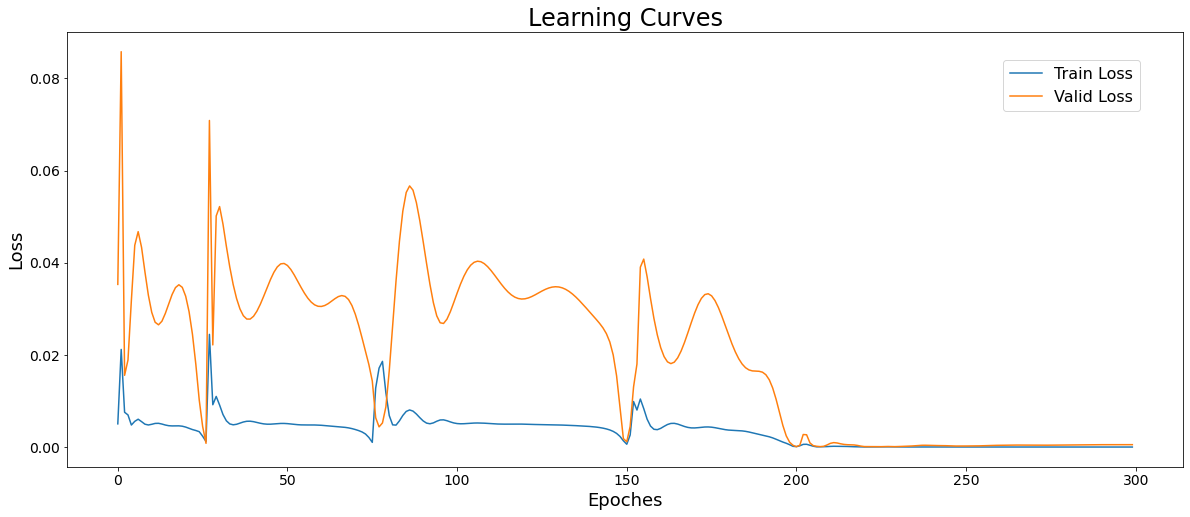

In [153]:
fig = plt.figure(figsize=(20,8))

plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")

plt.legend(loc='lower center', bbox_to_anchor=(0.9, 0.8), fontsize=16)

plt.title('Learning Curves', fontsize=24)
plt.xlabel('Epoches', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

# Save Model

In [135]:
torch.save(model.state_dict(), f"models/lstm-{nhidden}-{nlayers}--{time.strftime('%Y%m%d-%H%M%S')}")

# Load Model

In [13]:
model = LSTM(nin=nin, nhidden=nhidden, nout=nout, nlayers=nlayers)
model.load_state_dict(torch.load('models/lstm'))

<All keys matched successfully>

# Evaluate Model

In [154]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_train_pred = model(x_train_tensor)
y_valid_pred = model(x_valid_tensor)
y_test_pred = model(x_test_tensor)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_tensor.detach().numpy())
y_valid_pred = scaler.inverse_transform(y_valid_pred.detach().numpy())
y_valid = scaler.inverse_transform(y_valid_tensor.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_tensor.detach().numpy())

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
valid_score = math.sqrt(mean_squared_error(y_valid[:,0], y_valid_pred[:,0]))
print('Valid Score: %.2f RMSE' % (valid_score))
test_score = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 1.32 RMSE
Valid Score: 7.96 RMSE
Test Score: 57.96 RMSE


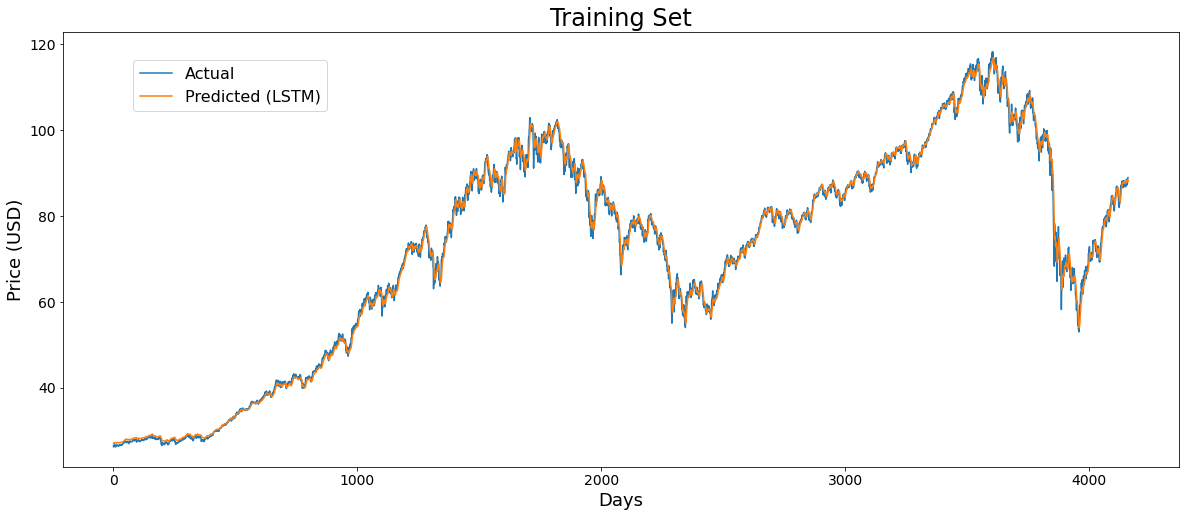

In [155]:
train_orig_pd = pd.DataFrame(y_train)
train_pred_pd = pd.DataFrame(y_train_pred)

plt.figure(figsize=(20,8))
plt.plot(train_orig_pd.index, train_orig_pd[0], label="Actual")
plt.plot(train_pred_pd.index, train_pred_pd[0], label="Predicted (LSTM)")

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.8), fontsize=16)

plt.title('Training Set', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

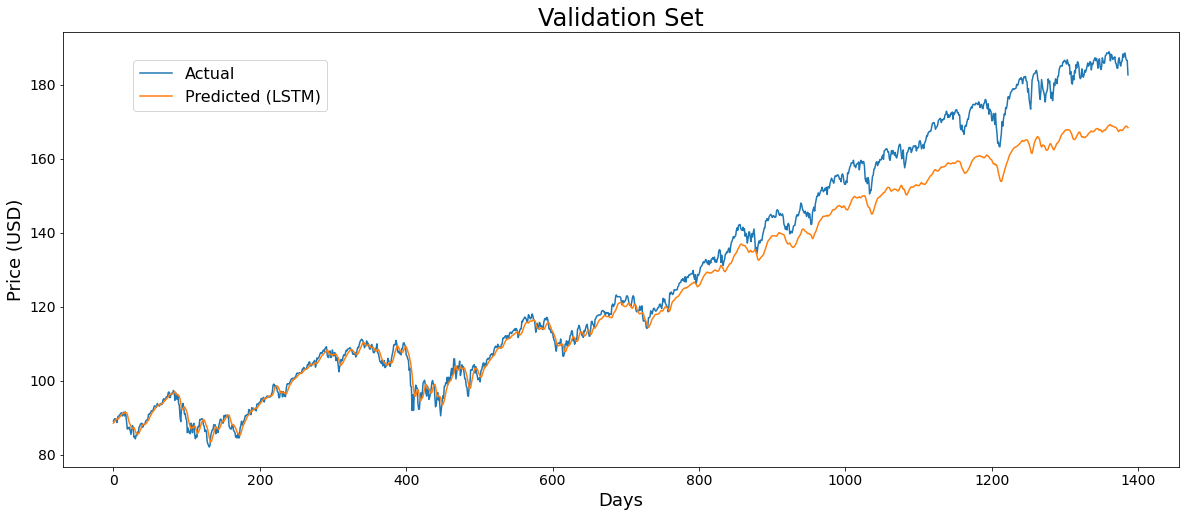

In [156]:
valid_orig_pd = pd.DataFrame(y_valid)
valid_pred_pd = pd.DataFrame(y_valid_pred)

plt.figure(figsize=(20,8))
plt.plot(valid_orig_pd.index, valid_orig_pd[0], label="Actual")
plt.plot(valid_pred_pd.index, valid_pred_pd[0], label="Predicted (LSTM)")

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.8), fontsize=16)

plt.title('Validation Set', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

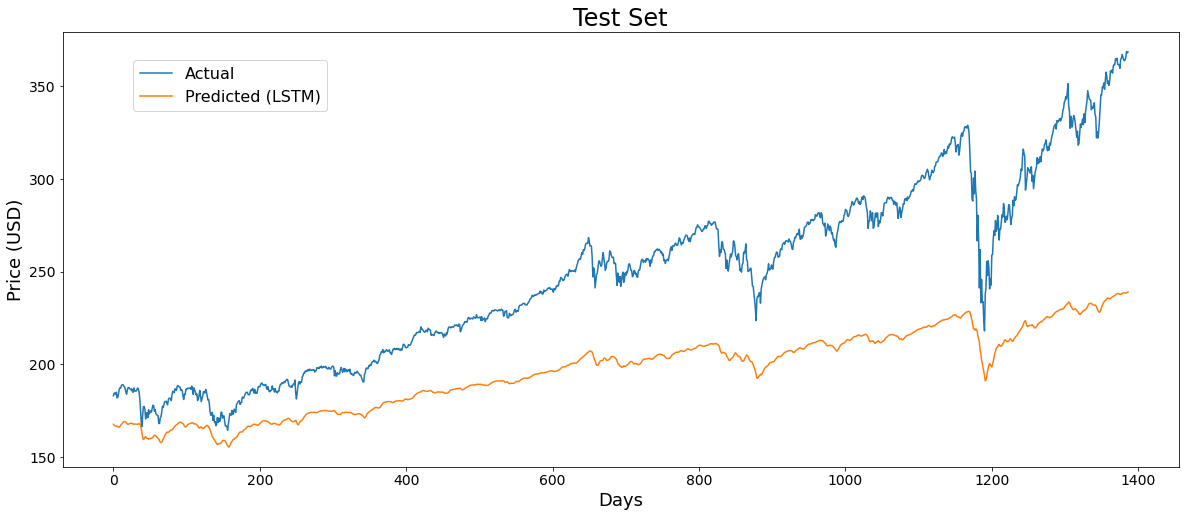

In [158]:
test_orig_pd = pd.DataFrame(y_test)
test_pred_pd = pd.DataFrame(y_test_pred)

plt.figure(figsize=(20,8))
plt.plot(test_orig_pd.index, test_orig_pd[0], label="Actual")
plt.plot(test_pred_pd.index, test_pred_pd[0], label="Predicted (LSTM)")

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.8), fontsize=16)

plt.title('Test Set', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [159]:
actual_change = (test_orig_pd.shift(-1) - test_orig_pd) / test_orig_pd
pred_change = (test_pred_pd.shift(-1) - test_pred_pd) / test_pred_pd
label_pred = pred_change > 0
label_actual = actual_change > 0
label = label_pred == label_actual
label.value_counts()

True     697
False    690
dtype: int64

In [160]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
print(f"Accuracy: {accuracy_score(label_actual, label_pred)}")
print(f"Precision: {precision_score(label_actual, label_pred)}")
print(f"Recall: {recall_score(label_actual, label_pred)}")

Accuracy: 0.5025234318673396
Precision: 0.5443322109988776
Recall: 0.6306892067620286


                 0
count  1386.000000
mean      0.000259
std       0.002582
min      -0.020831
25%      -0.000503
50%       0.000487
75%       0.001529
max       0.015760


{'whiskers': [<matplotlib.lines.Line2D at 0x28c38e670>,
 'caps': [<matplotlib.lines.Line2D at 0x28c38efd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x28c38edf0>],
 'medians': [<matplotlib.lines.Line2D at 0x28c3300d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x28c3307f0>],
 'means': []}

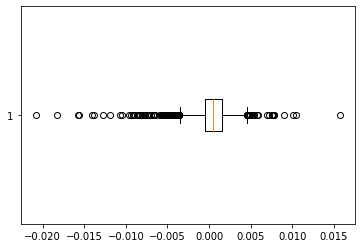

In [161]:
changes = []
for idx, change in enumerate(pred_change[:-1].to_numpy().reshape(-1)):
    changes.append(change)
print(pd.DataFrame(changes).describe())
plt.boxplot(changes, vert=False)

In [171]:
def mark(row):
    if row['change'] > 0.0004:
        return 'B'
    elif row['change'] < -0.0004:
        return 'S'
    else:
        return 'H'

lstmd = data[-1387:-1]
lstmd['change'] = pred_change[:-1].to_numpy().reshape(-1)
lstmd['action'] = lstmd.apply(lambda row: mark(row), axis=1)

lstm_perf = evaluation.eval(lstmd)

Performance: 67.42%


/var/folders/tv/g_tbbk8n6pj4f83qptc1qf6c0000gn/T/ipykernel_40110/3034282536.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstmd['change'] = pred_change[:-1].to_numpy().reshape(-1)
/var/folders/tv/g_tbbk8n6pj4f83qptc1qf6c0000gn/T/ipykernel_40110/3034282536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstmd['action'] = lstmd.apply(lambda row: mark(row), axis=1)


In [62]:
macd_perf = evaluation.eval(strategy.macd(data))

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Performance: 176.58%


In [63]:
bh_perf = evaluation.eval(strategy.bh(data))

Performance: 98.84%


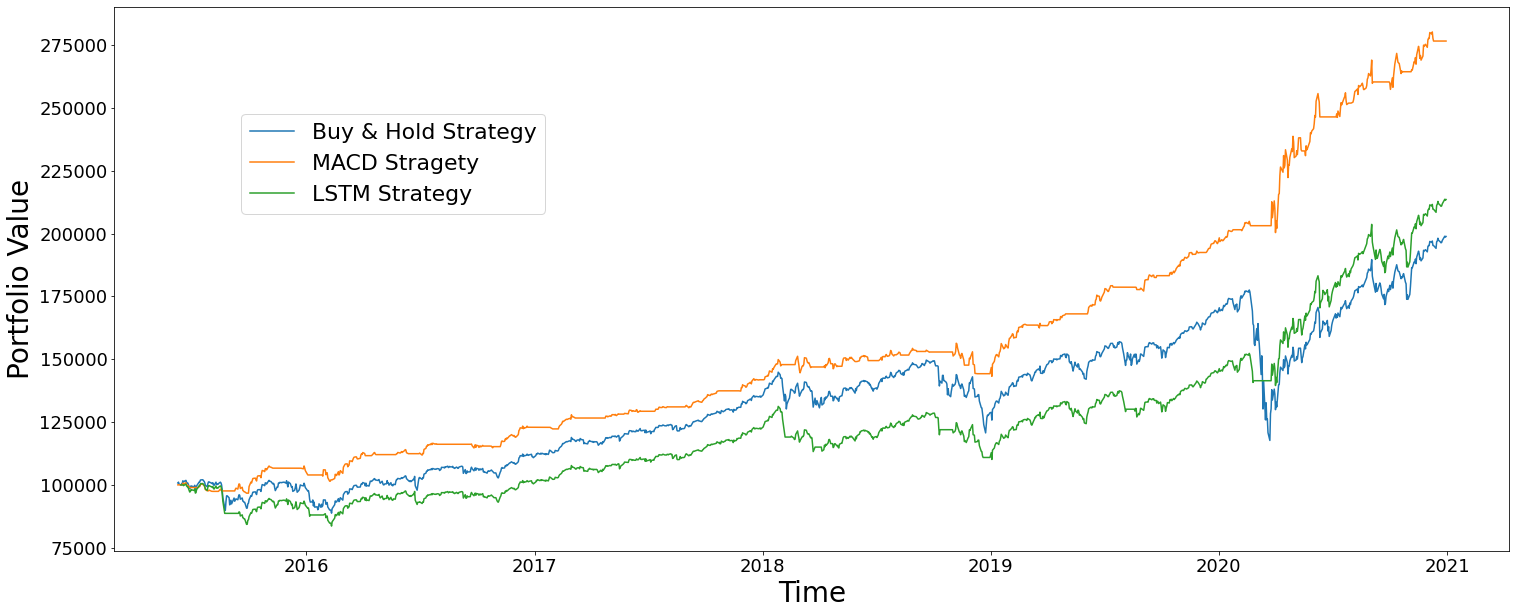

In [121]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['value'], label='Buy & Hold Strategy')
plt.plot(macd_perf['value'], label='MACD Stragety')
plt.plot(lstm_perf['value'], label='LSTM Strategy')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Portfolio Value', fontsize=28)

plt.show()

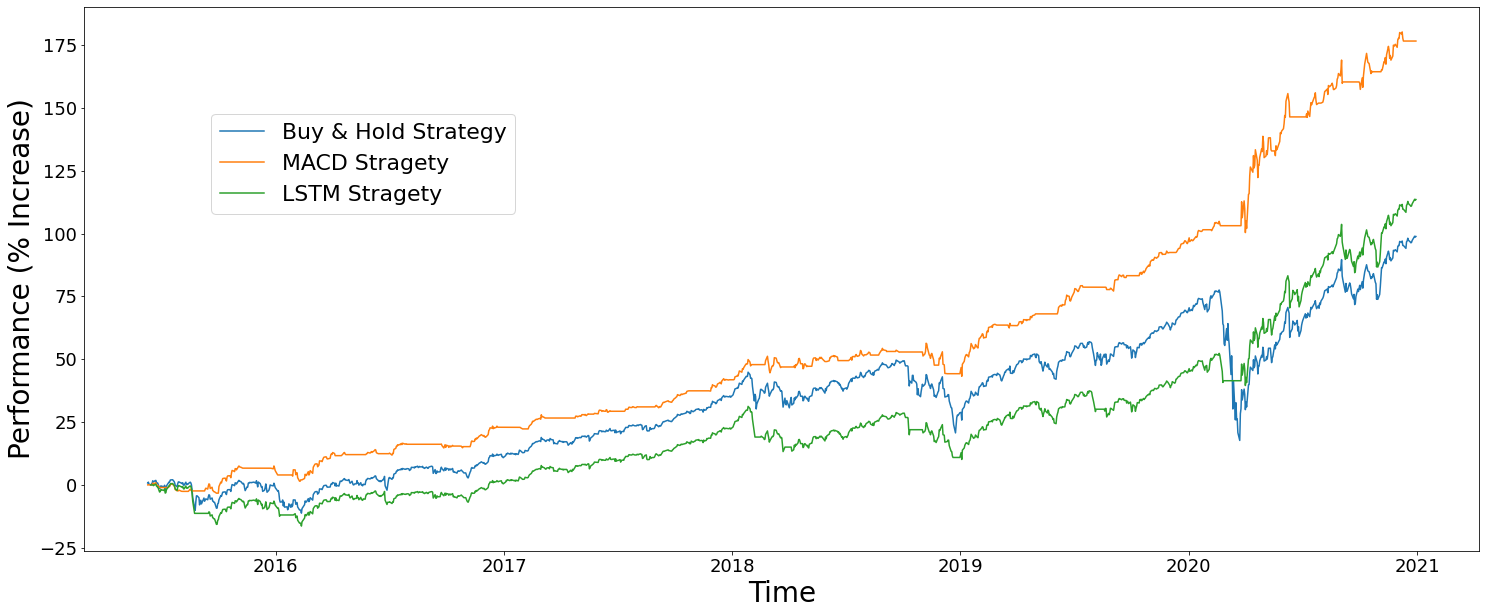

In [130]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['percentage'], label='Buy & Hold Strategy')
plt.plot(macd_perf['percentage'], label='MACD Stragety')
plt.plot(lstm_perf['percentage'], label='LSTM Stragety')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Performance (% Increase)', fontsize=28)

plt.show()

In [30]:
bh_perf.to_csv('evals/bh.csv')
macd_perf.to_csv('evals/macd.csv')
lstm_perf.to_csv('evals/lstm.csv')